# Demo of SAST transform

## Credit
This demo is a copy of the ROCKET demo, where SAST replaces ROCKET. Since SAST does not handle multivariate time series yet, multivariate sections are removed

## Overview

SAST [1]_ first randomly selects k time series from each class (they are called reference time series). Then SAST generates all the subsequences of the specified lengths from these reference time series. These subsequences are then used to transform a time series dataset, replacing each time series by the vector of its distance to each subsequence.

[1] Mbouopda, Michael Franklin, and Engelbert Mephu Nguifo. "Scalable and accurate subsequence transform for time series classification." Pattern Recognition 147 (2023): 110121, https://www.sciencedirect.com/science/article/abs/pii/S003132032300818X, https://uca.hal.science/hal-03087686/document

***

## Contents

1. Imports
2. Univariate Time Series
4. Pipeline Example
5. SASTClassifier Example

***

## 1 Imports

Import example data, SAST, and a classifier (`RidgeClassifierCV` from scikit-learn), as well as NumPy and `make_pipeline` from scikit-learn.

**Note**: SAST compiles (via Numba) on import, which may take a few seconds.

In [1]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from aeon.classification.shapelet_based import SASTClassifier
from aeon.datasets import load_classification
from aeon.transformations.collection.shapelet_based import SAST

## 2 Univariate Time Series

We can transform the data using SAST and separately fit a classifier, or we can use SAST together with a classifier in a pipeline (section 4, below).

### 2.1 Load the Training Data
For more details on the data set, see the [univariate time series classification
notebook](https://github.com/aeon-toolkit/aeon/tree/main/examples/classification/classification.ipynb).

In [2]:
X_train, y_train = load_classification("UnitTest", split="train")

### 2.2 Initialise SAST and Transform the Training Data

In [3]:
sast = SAST()
sast.fit(X_train, y_train)
X_train_transform = sast.transform(X_train)

### 2.3 Fit a Classifier

We recommend using `RidgeClassifierCV` from scikit-learn for smaller datasets (fewer than approx. 20K training examples), and using logistic regression trained using stochastic gradient descent for larger datasets.

In [4]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

### 2.4 Load and Transform the Test Data

In [5]:
X_test, y_test = load_classification("UnitTest", split="test")
X_test_transform = sast.transform(X_test)

### 2.5 Classify the Test Data

In [6]:
classifier.score(X_test_transform, y_test)

0.8636363636363636

***

## 3 Pipeline Example

We can use SAST together with `RidgeClassifierCV` (or another classifier) in a pipeline.  We can then use the pipeline like a self-contained classifier, with a single call to `fit`, and without having to separately transform the data, etc.

### 3.1 Initialise the Pipeline

In [7]:
sast_pipeline = make_pipeline(SAST(), RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))

### 3.2 Load and Fit the Training Data

In [8]:
X_train, y_train = load_classification("UnitTest", split="train")

# it is necessary to pass y_train to the pipeline
# y_train is not used for the transform, but it is used by the classifier
sast_pipeline.fit(X_train, y_train)

Pipeline(steps=[('sast', SAST()),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])))])

### 3.3 Load and Classify the Test Data

In [9]:
X_test, y_test = load_classification("UnitTest", split="test")

sast_pipeline.score(X_test, y_test)

0.8636363636363636

## 4 SASTClassifier Example
This is a wrapper for building a pipeline seamelessly using SAST transformer

### 4.1 Ininitialize the classifier

In [10]:
clf = SASTClassifier(seed=42)
clf

SASTClassifier(seed=42)

### 4.2 Fit the classifier on the training data

In [11]:
clf.fit(X_train, y_train)

SASTClassifier(seed=42)

### 4.3 Classify the test data

In [12]:
clf.score(X_test, y_test)

0.8636363636363636

### 4.4 Interpretability

SASTClassifier's interpretability can be achieved by visualizing the most important subsequences used for the transformation.

The importance of features can be computed by different means. In this demo, we considere the absolute values of the weights of the ridge classifier as the feature importances.

#### 4.4.1 Interpretability of class `1`

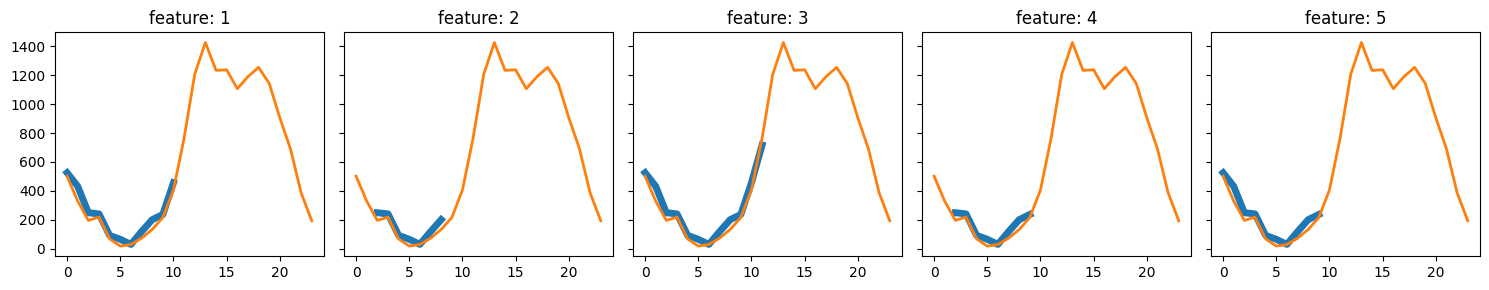

In [13]:
fig = clf.plot_most_important_feature_on_ts(
    X_test[y_test == "1"][0, 0], clf._classifier.coef_
)

#### 4.4.2 Interpretability of class `2`

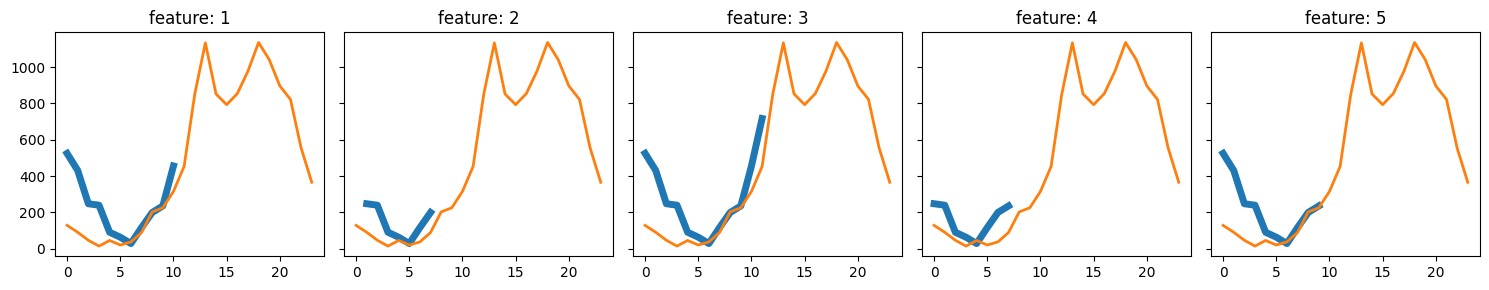

In [14]:
fig = clf.plot_most_important_feature_on_ts(
    X_test[y_test == "2"][0, 0], clf._classifier.coef_
)

#### 4.4.3 Interpretability summary

We can see that the most important subsequences matche the instance from class `1` quite exactly, meaning that these subsequences are characteristic of this class.
On the contrary, they failed to match the instance from class `2`. These subsequences can be called Shapelets for this dataset.

Feel free to play with different time series from the dataset, or with a different dataset

### References
[1] Michael F Mbouopda •, Engelbert Mephu. Scalable and Accurate Subsequence Transform.